In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_applications

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-u72psuti
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-u72psuti
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=ea88806578e223943e95734a0e191d9fbde17db36f00c4a6ccc32e4e113cdeda
  Stored in directory: /tmp/pip-ephem-wheel-cache-tswcxz89/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
     |████████████████████████████████| 51kB 2.7MB/s 


In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import resample
import io
# from keras_vggface.vggface import VGGFace
from skimage.transform import resize


dataset = pd.read_csv('/content/drive/My Drive/fer2013.csv')


In [4]:
def convert_pixels_to_img(pixels):
    pixels = pixels/255
    test_image = pixels.reshape(48,48)
    test_image = resize(test_image, (75, 75))


    return test_image

def split_pixels(string):
    splitted = np.array(string.split(),'int')
    return splitted 

def change_to_categorical(sample):
    return keras.utils.to_categorical(sample,num_classes=7)

def grayscale_to_rgb(grayscale_image): 
    rgb_image = np.stack((grayscale_image,)*3, axis=-1)
    return rgb_image 

dataset['pixels'] = dataset['pixels'].apply(split_pixels)
dataset['label'] = dataset['emotion'].apply(change_to_categorical)
dataset['length'] = dataset['pixels'].apply(len)

dataset = dataset[dataset.length == 2304]
dataset['image'] = dataset['pixels'].apply(convert_pixels_to_img)
dataset['image'] = dataset['image'].apply(grayscale_to_rgb)

grouped_dataset = dataset.groupby(dataset.Usage)
training_dataset = grouped_dataset.get_group("Training")
dev_dataset = grouped_dataset.get_group("PublicTest")
test_dataset = grouped_dataset.get_group("PrivateTest")


# def balancingDataset(data, x):
#     new_df = data.loc[data['emotion']==x]
#     data_to_add = 8000 - len(new_df)
#     random_sampling = resample(new_df,random_state=42,replace=True,n_samples=data_to_add)
#     return pd.concat([new_df,random_sampling])

# df_0=balancingDataset(training_dataset,0)
# df_2=balancingDataset(training_dataset,2)
# df_3=balancingDataset(training_dataset,3)
# df_4=balancingDataset(training_dataset,4)
# df_5=balancingDataset(training_dataset,5)
# df_6=balancingDataset(training_dataset,6)


# training_dataset_aug=pd.concat([df_0,df_2,df_3,df_4,df_5,df_6])

# Pandas dataframe
x_train = training_dataset['image']
y_train = training_dataset['label']
x_test =  dev_dataset['image']
y_test = dev_dataset['label']

#Pandas dataframe to numpy
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

#numpy array reshape to fit into model
x_train = np.stack(x_train,axis=0)
y_train = np.stack(y_train,axis=0)
x_test = np.stack(x_test,axis=0)
y_test = np.stack(y_test,axis=0)



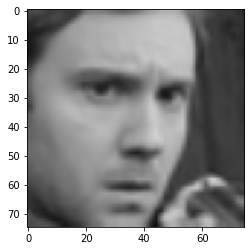

In [5]:
plt.imshow(x_train[0]) 

In [8]:
emotion_labels = {0:'Angry', 1:'Disgust',2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
def int_to_emotion(x):
    return emotion_labels[x]
def get_distribution(data):
    emotion_count = data['emotion'].value_counts()
    
    #emotion_count.index = emotion_count.index.map(int_to_emotion)
    print("Distribution count of emotions in the dataset:")
    print(emotion_count)
    print("")
    dict_count = emotion_count.to_dict()
    class_weights = {}
    total_samples = sum(list(dict_count.values()))
    for c in dict_count.keys():
        weight = (1/dict_count[c]) * (total_samples/2)
        class_weights[c] = weight 
    print(class_weights)
    return class_weights

class_weights = get_distribution(training_dataset)  

Distribution count of emotions in the dataset:
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: emotion, dtype: int64

{3: 1.9895356895356895, 6: 2.8911379657603224, 4: 2.9719461697722567, 2: 3.503661215523554, 0: 3.5931163954943677, 5: 4.526805424156418, 1: 32.92316513761468}


In [9]:

datagen = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        shear_range = 10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)
generator=datagen.flow(x_train,y_train,batch_size=64)

In [10]:
from tensorflow.keras.applications import InceptionResNetV2

inception = InceptionResNetV2(include_top=False,weights='imagenet',input_shape=(75,75,3))

x = inception.output
x = layers.Flatten()(x)
x = layers.Dense(units=4096,activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(units=2048, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(units=7, activation="softmax")(x)

new_model = keras.Model(inputs=inception.input, outputs=x)

lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5)
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=30, mode='auto')
checkpointer = ModelCheckpoint('/content/drive/My Drive/Colab Notebooks/Emotion Recognition/Model/inception_sgd_classweights.h5', monitor='val_loss', verbose=1, save_best_only=True)


new_model.compile(optimizer='sgd',loss='categorical_crossentropy',metrics=['accuracy'])
new_model.summary()

history = new_model.fit(generator,batch_size=64,epochs=200,verbose=1,
                        validation_data=(x_test, y_test),callbacks=[lr_reducer,early_stopper,checkpointer],class_weight=class_weights)


219062272/219055592 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
___________________________

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


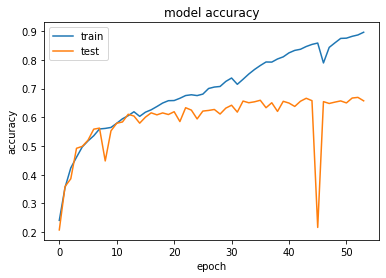

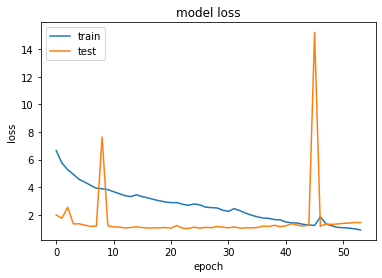

In [11]:
import matplotlib.pyplot as plt
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:

x_test =  test_dataset['image']
y_test = test_dataset['label']

#Pandas dataframe to numpy
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

#numpy array reshape to fit into model
x_test = np.stack(x_test,axis=0)
y_test = np.stack(y_test,axis=0)

In [13]:
new_model.evaluate(x_test,y_test)

113/113 [==============================] - 4s 38ms/step - loss: 1.3388 - accuracy: 0.6790


[1.3387558460235596, 0.6790192127227783]

In [14]:
y_pred = new_model.predict(x_test)

In [19]:
import sklearn
from sklearn.metrics import confusion_matrix 
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))


In [20]:
print(matrix)

[[314   3  49   7  63  13  42]
 [  8  40   1   2   3   0   1]
 [ 79   6 255  10  85  42  51]
 [ 33   0  18 734  33  16  45]
 [ 72   2  48  22 328  16 106]
 [ 20   1  17  11   8 351   8]
 [ 46   1  27  30  94  13 415]]


Confusion matrix, without normalization
[[314   3  49   7  63  13  42]
 [  8  40   1   2   3   0   1]
 [ 79   6 255  10  85  42  51]
 [ 33   0  18 734  33  16  45]
 [ 72   2  48  22 328  16 106]
 [ 20   1  17  11   8 351   8]
 [ 46   1  27  30  94  13 415]]


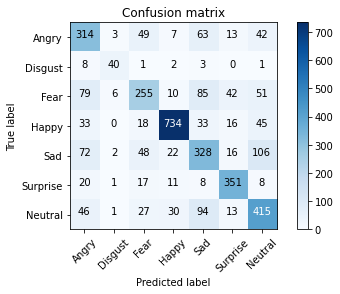

In [22]:
import itertools
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm=matrix,classes=['Angry', 'Disgust','Fear', 'Happy', 'Sad','Surprise', 'Neutral'])